In [1]:
import os
import shutil
from pathlib import Path
from pprint import pprint
from IPython.display import display

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image

%matplotlib inline

## Preprocess metadata file

In [2]:
# Two metadata file
# Metadata file in this format :
# dish_id, total_calories, total_mass, total_fat, total_carb, total_protein, num_ingrs, (ingr_1_id, ingr_1_name, ingr_1_grams, ingr_1_calories, ingr_1_fat, ingr_1_carb, ingr_1_protein, ...)

dish_metadata1 = Path("./nutrition5k/metadata/dish_metadata_cafe1.csv")
dish_metadata2 = Path("./nutrition5k/metadata/dish_metadata_cafe2.csv")
ingredients_metadata = pd.read_csv("./nutrition5k/metadata/ingredients_metadata.csv")

In [3]:
ingredients_metadata

ingr   id  cal/g  fat(g)  carb(g)  protein(g)
0    cottage cheese    1  0.980   0.043    0.034       0.110
1      strawberries    2  0.330   0.003    0.080       0.007
2      garden salad    3  0.646   0.034    0.032       0.061
3             bacon    4  5.410   0.420    0.014       0.370
4          potatoes    5  0.770   0.001    0.170       0.020
..              ...  ...    ...     ...      ...         ...
550     pizza sauce  551  0.290   0.002    0.070       0.013
551     pomegranate  552  0.830   0.012    0.190       0.017
552      nut cheese  553  2.100   0.101    0.040       0.256
553     soy sausage  554  2.020   0.144    0.063       0.160
554             oil  555  8.864   1.000    0.000       0.000

[555 rows x 6 columns]

In [4]:
# dish_metadata1 convert into structured csv file with (dish_id, calories / g, fat/g, carbs/g, protein/g, ingredients as string)
# Cleaning dish_metadata1 calculate nutritional values per gram and extract ingredients information into a structured DataFrame
rows = []
with open(dish_metadata1) as file:
    for line in file.readlines():
        row = []
        content = line.split(",")
        row.append(content[0])
        row.append("generic")
        total_calorie = float(content[1])
        total_mass = float(content[2])
        total_fat = float(content[3])
        total_carb = float(content[4])
        total_protein = float(content[5])
        # Calculate per gram values
        row.extend(
            [
                total_calorie / total_mass,
                total_carb / total_mass,
                total_protein / total_mass,
                total_fat / total_mass,
            ]
        )
        # Extract ingredients list
        ingredients_content = content[6:]
        ingredients_list = []
        for i in range(1, len(ingredients_content), 7):
            if ingredients_content[i] == "":
                ingredient_no = int(ingredients_content[i - 1].split("_")[1])
                ingredient_name = ingredients_metadata.at[ingredient_no - 1, "ingr"]
                ingredients_list.append(ingredient_name)
            else:
                ingredients_list.append(ingredients_content[i])
        row.append(",".join(ingredients_list))
        rows.append(row)
cleaned_dish_metadata1 = pd.DataFrame(
    rows,
    columns=[
        "dish_id",
        "Category",
        "Calorie(kcal)",
        "Carbohydrate(g)",
        "Protein(g)",
        "Fat(g)",
        "Ingredients",
    ],
)

In [5]:
cleaned_dish_metadata1.head()

dish_id Category  Calorie(kcal)  Carbohydrate(g)  Protein(g)  \
0  dish_1561662216  generic       1.558520         0.146209    0.096549   
1  dish_1562688426  generic       1.563295         0.058977    0.117011   
2  dish_1561662054  generic       1.436434         0.090245    0.088735   
3  dish_1562008979  generic       1.320471         0.035081    0.121881   
4  dish_1560455030  generic       0.199903         0.044903    0.009282   

     Fat(g)                                        Ingredients  
0  0.064184  soy sauce,garlic,white rice,parsley,onions,bro...  
1  0.093818             roasted potatoes,chicken apple sausage  
2  0.081638  pepper,white rice,mixed greens,garlic,soy sauc...  
3  0.076637  jalapenos,lemon juice,pork,wheat berry,cabbage...  
4  0.001437             cherry tomatoes,cucumbers,baby carrots

**Note : An ingredient named "deprecated" is present after several checked it might be heavily linked to foods**

In [6]:
# dish_metadata2 convert into structured csv file with (dish_id, calories / g, fat/g, carbs/g, protein/g, ingredients as string)
# dish_metadata2 did not provide dish level nutrition info, manual add up is required
# Cleaning dish_metadata2 calculating nutritional values per gram and extracting ingredients
rows = []
with open(dish_metadata2) as file:
    for line in file.readlines():
        row = []
        content = line.split(",")
        row.append(content[0])
        row.append("generic")
        total_mass = float(content[2])
        ingredients_content = content[6:]
        ingredients_list = []
        # Initialize total nutritional values from ingredients
        total_calorie_from_ingr = 0
        total_carbs_from_ingr = 0
        total_protein_from_ingr = 0
        total_fat_from_ingr = 0
        # Iterate through ingredients data
        for i in range(0, len(ingredients_content), 7):
            if ingredients_content[i + 1] == "":
                ingredient_no = int(ingredients_content[i].split("_")[1])
                ingredient_name = ingredients_metadata.at[ingredient_no - 1, "ingr"]
                ingredients_list.append(ingredient_name)
            else:
                ingredients_list.append(ingredients_content[i + 1])
            # Accumulate total nutritional values
            total_calorie_from_ingr += float(ingredients_content[i + 3])
            total_fat_from_ingr += float(ingredients_content[i + 4])
            total_carbs_from_ingr += float(ingredients_content[i + 5])
            total_protein_from_ingr += float(ingredients_content[i + 6])
        # Calculate per gram values
        total_calorie = total_calorie_from_ingr
        total_carb = total_carbs_from_ingr
        total_protein = total_protein_from_ingr
        total_fat = total_fat_from_ingr
        row.extend(
            [
                total_calorie / total_mass,
                total_carb / total_mass,
                total_protein / total_mass,
                total_fat / total_mass,
            ]
        )

        row.append(",".join(ingredients_list))
        rows.append(row)
cleaned_dish_metadata2 = pd.DataFrame(
    rows,
    columns=[
        "dish_id",
        "Category",
        "Calorie(kcal)",
        "Carbohydrate(g)",
        "Protein(g)",
        "Fat(g)",
        "Ingredients",
    ],
)

In [7]:
cleaned_dish_metadata2.head()

dish_id Category  Calorie(kcal)  Carbohydrate(g)  Protein(g)  \
0  dish_1572974428  generic       1.954041         0.161582    0.043231   
1  dish_1572464692  generic       1.660000         0.140000    0.079000   
2  dish_1571931594  generic       1.410000         0.180000    0.021000   
3  dish_1575478635  generic       1.480000         0.016000    0.100000   
4  dish_1572887017  generic       0.917682         0.064411    0.076443   

     Fat(g)                                        Ingredients  
0  0.138704  tomatoes,avocado,multigrain bread,olive oil,ed...  
1  0.096000                                             hummus  
2  0.068000                                   roasted potatoes  
3  0.110000                                     scrambled eggs  
4  0.036212                       hash browns,egg whites,salsa

In [8]:
len(cleaned_dish_metadata1)

4768

In [9]:
# Concat both dataset together
cleaned_metadata = pd.concat([cleaned_dish_metadata1, cleaned_dish_metadata2])

In [10]:
cleaned_metadata = cleaned_metadata.reset_index(drop=True)

In [11]:
cleaned_metadata

dish_id Category  Calorie(kcal)  Carbohydrate(g)  Protein(g)  \
0     dish_1561662216  generic       1.558520         0.146209    0.096549   
1     dish_1562688426  generic       1.563295         0.058977    0.117011   
2     dish_1561662054  generic       1.436434         0.090245    0.088735   
3     dish_1562008979  generic       1.320471         0.035081    0.121881   
4     dish_1560455030  generic       0.199903         0.044903    0.009282   
...               ...      ...            ...              ...         ...   
5001  dish_1571934465  generic       0.330000         0.080000    0.007000   
5002  dish_1573073666  generic       0.549019         0.077154    0.024811   
5003  dish_1575924356  generic       1.316000         0.248000    0.051000   
5004  dish_1574359199  generic       1.506565         0.118590    0.059204   
5005  dish_1576171157  generic       1.002627         0.065226    0.076498   

        Fat(g)                                        Ingredients  
0     0.064184  soy sauce,garlic,white rice,parsley,onions,bro...  
1     0.093818             roasted potatoes,chicken apple sausage  
2     0.081638  pepper,white rice,mixed greens,garlic,soy sauc...  
3     0.076637  jalapenos,lemon juice,pork,wheat berry,cabbage...  
4     0.001437             cherry tomatoes,cucumbers,baby carrots  
...        ...                                                ...  
5001  0.003000                                       strawberries  
5002  0.022488     broccoli,olive oil,bread crumbs,salt,jalapenos  
5003  0.011000                                              pasta  
5004  0.086729             scrambled eggs,roasted potatoes,crepes  
5005  0.053859  brussels sprouts,almonds,olive oil,chili,salt,...  

[5006 rows x 7 columns]

### Remove rows without image data

Retrieves directories containing images, then filters the metadata DataFrame to remove rows where corresponding image directories do not exist.

In [12]:
source_dir = Path("./nutrition5k/imagery/side_angles")
source_dir2 = Path("./nutrition5k/imagery/realsense_overhead")
all_dir = [x.name for x in source_dir.iterdir()]
all_dir2 = [x.stem for x in source_dir2.iterdir()]

In [13]:
all_dir = set(all_dir)
all_dir.update(all_dir2)

In [14]:
# remove rows without image data
all_dish_id = cleaned_metadata["dish_id"]
for dish in all_dish_id:
    if dish not in all_dir:
        index_to_drop = cleaned_metadata[cleaned_metadata["dish_id"] == dish].index
        cleaned_metadata = cleaned_metadata.drop(index_to_drop)

In [15]:
# Asserts that the number of entries in all_dir matches the number of entries in cleaned_metadata
assert len(all_dir) == len(
    cleaned_metadata
), "The total entries of metadata does not matched with the total dish_id in image directory"

### Check for ingredients validity

In [16]:
# Check for ingredients
# Reads the ingredients metadata CSV file and displays a sorted list of ingredients.
df_ingredients = pd.read_csv("./nutrition5k/metadata/ingredients_metadata.csv")

In [17]:
pprint(sorted(df_ingredients["ingr"].tolist()))

['agave nectar',
 'alcohol',
 'alfalfa',
 'almond butter',
 'almond milk',
 'almonds',
 'american cheese',
 'anchovies',
 'apple',
 'apple cider',
 'apple juice',
 'apple pie',
 'applesauce',
 'apricots',
 'artic char',
 'artichokes',
 'arugula',
 'asparagus',
 'avocado',
 'baby carrots',
 'bacon',
 'bagels',
 'baked beans',
 'baked potatoes',
 'balsamic vinegar',
 'banana',
 'banana with peel',
 'barbecue sauce',
 'barley',
 'basil',
 'bean sprouts',
 'bean(seed) ',
 'beef',
 'beer',
 'beets',
 'bell peppers',
 'berries',
 'biscuits',
 'bison',
 'black beans',
 'blackberries',
 'blue cheese',
 'blueberries',
 'blueberry pie',
 'bok choy',
 'bologna',
 'brazil nuts',
 'bread',
 'bread crumbs',
 'breadsticks',
 'brie cheese',
 'brisket',
 'broccoli',
 'broth',
 'brown rice',
 'brown sugar',
 'brownies',
 'brussels sprouts',
 'bulgur',
 'buns',
 'burgers',
 'burritos',
 'butter',
 'buttermilk',
 'cabbage',
 'caesar dressing',
 'caesar salad',
 'cakes',
 'calamari',
 'calzones',
 'camembe

In [18]:
# Identifies rows in cleaned_metadata where the "Ingredients" column contains the substring "deprecated" and displays those rows.
rows_with_invalid_ingredients = cleaned_metadata[
    cleaned_metadata["Ingredients"].str.contains("deprecated")
]
display(rows_with_invalid_ingredients)

dish_id Category  Calorie(kcal)  Carbohydrate(g)  Protein(g)  \
5     dish_1558372433  generic       0.520000         0.003000    0.140000   
86    dish_1558114086  generic       0.520000         0.003000    0.140000   
190   dish_1558027001  generic       0.300000         0.076000    0.006000   
489   dish_1558373159  generic       3.033943         0.091332    0.181512   
858   dish_1558115364  generic       1.550351         0.084677    0.126070   
1021  dish_1558114875  generic       0.520000         0.003000    0.140000   
1087  dish_1558375506  generic       0.520000         0.003000    0.140000   
1335  dish_1558028142  generic       0.300000         0.076000    0.006000   
1504  dish_1558031019  generic       1.047929         0.154437    0.037122   
1574  dish_1558030724  generic       0.300000         0.076000    0.006000   
1656  dish_1558109945  generic       0.520000         0.003000    0.140000   
1679  dish_1558027243  generic       1.615736         0.151521    0.076982   
1931  dish_1558373074  generic       0.520000         0.003000    0.140000   
2077  dish_1558379876  generic       3.070190         0.085952    0.182599   
2181  dish_1558115282  generic       0.520000         0.003000    0.140000   
2199  dish_1558379588  generic       0.520000         0.003000    0.140000   
2450  dish_1558376984  generic       1.919080         0.086371    0.129829   
2618  dish_1558028606  generic       0.300000         0.076000    0.006000   
2654  dish_1558122740  generic       0.855757         0.074424    0.094141   
2711  dish_1558116547  generic       0.520000         0.003000    0.140000   
2741  dish_1558115047  generic       0.960849         0.035689    0.120651   
2755  dish_1558380152  generic       0.520000         0.003000    0.140000   
3086  dish_1558375583  generic       1.538382         0.020813    0.149390   
3282  dish_1558031394  generic       0.746572         0.174453    0.013302   
3398  dish_1558114284  generic       0.513386         0.071421    0.067472   
3599  dish_1558028772  generic       0.333333         0.082083    0.006292   
3605  dish_1558031351  generic       0.300000         0.076000    0.006000   
3644  dish_1558376768  generic       0.520000         0.003000    0.140000   
3645  dish_1558372771  generic       1.680418         0.085881    0.123177   
3774  dish_1558380181  generic       1.197879         0.104540    0.092722   
4507  dish_1558028194  generic       1.325872         0.104709    0.071035   

        Fat(g)                                     Ingredients  
5     0.002000                                      deprecated  
86    0.002000                                      deprecated  
190   0.001000                                      deprecated  
489   0.236880                      sausage,deprecated,almonds  
858   0.086291               potatoes,deprecated,almonds,bacon  
1021  0.002000                                      deprecated  
1087  0.002000                                      deprecated  
1335  0.001000                                      deprecated  
1504  0.033269            yam,bacon,deprecated,honeydew melons  
1574  0.001000                                      deprecated  
1656  0.002000                                      deprecated  
1679  0.078515                            deprecated,bacon,yam  
1931  0.002000                                      deprecated  
2077  0.240019                      deprecated,sausage,almonds  
2181  0.002000                                      deprecated  
2199  0.002000                                      deprecated  
2450  0.130240  almonds,deprecated,sausage,mixed greens,grapes  
2618  0.001000                                      deprecated  
2654  0.025339   grapes,mixed greens,deprecated,potatoes,bacon  
2711  0.002000                                      deprecated  
2741  0.048972                 mixed greens,almonds,deprecated  
2755  0.002000                                      deprecated  
3086  0.098251        

dish_1558372433 : 


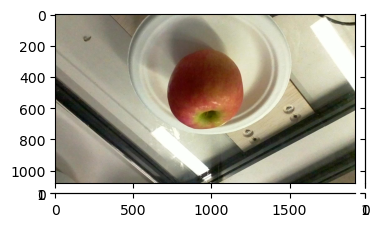

dish_1558114086 : 


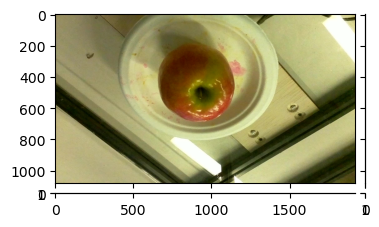

dish_1558027001 : 


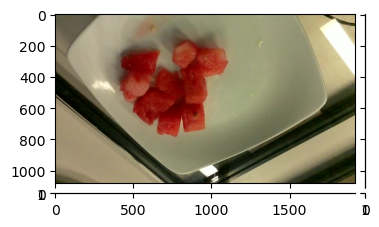

dish_1558373159 : 


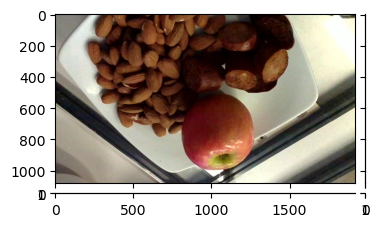

dish_1558115364 : 


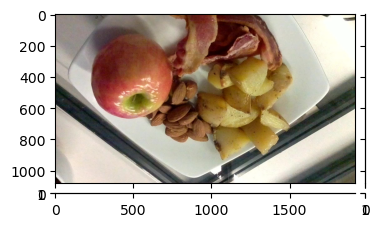

dish_1558114875 : 


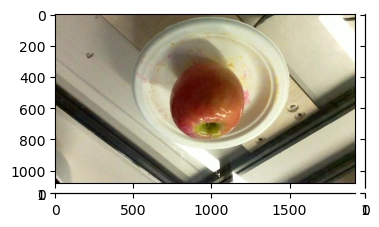

dish_1558375506 : 


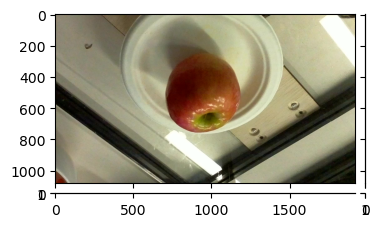

dish_1558028142 : 


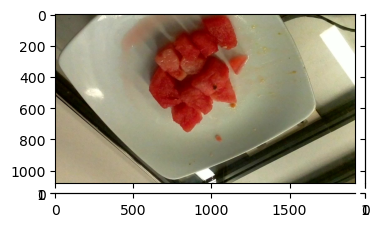

dish_1558031019 : 


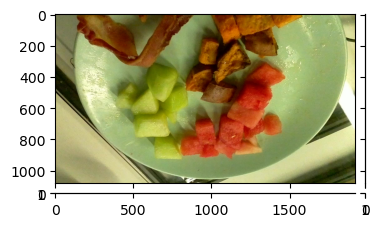

dish_1558030724 : 


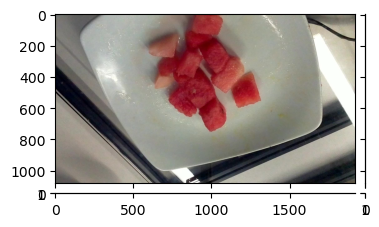

dish_1558109945 : 


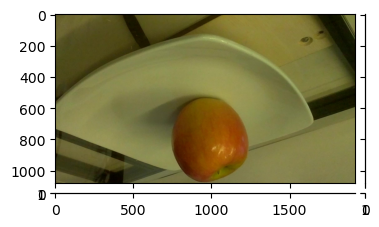

dish_1558027243 : 


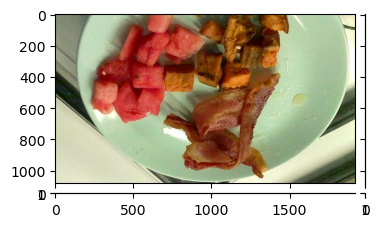

dish_1558373074 : 


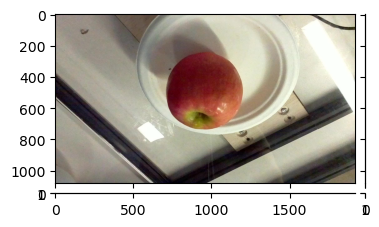

dish_1558379876 : 


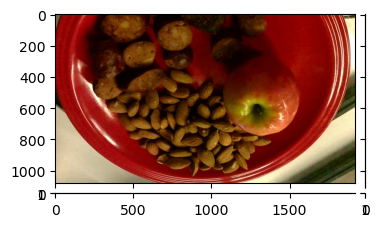

dish_1558115282 : 


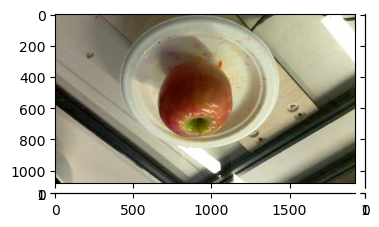

dish_1558379588 : 


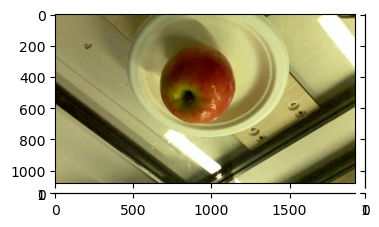

dish_1558376984 : 


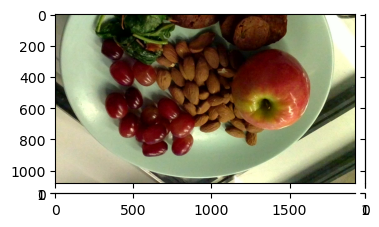

dish_1558028606 : 


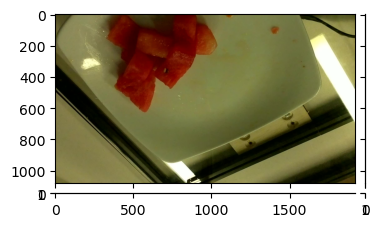

dish_1558122740 : 


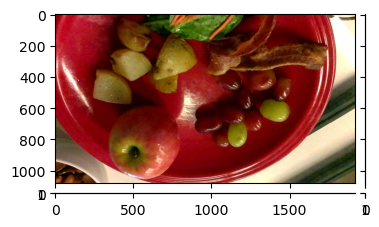

dish_1558116547 : 


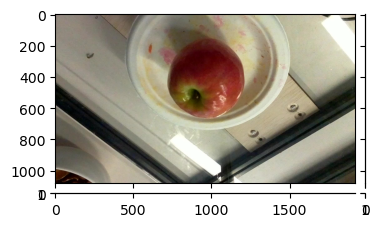

dish_1558115047 : 


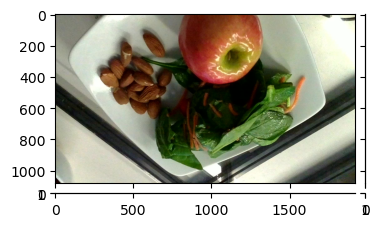

dish_1558380152 : 


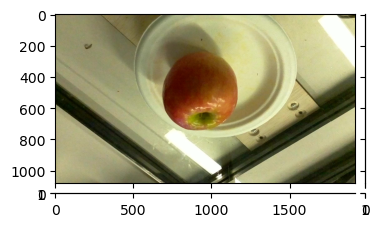

dish_1558375583 : 


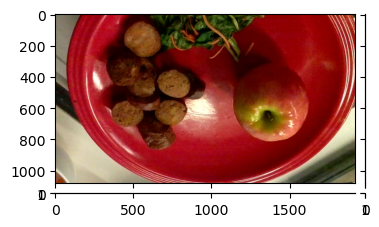

dish_1558031394 : 


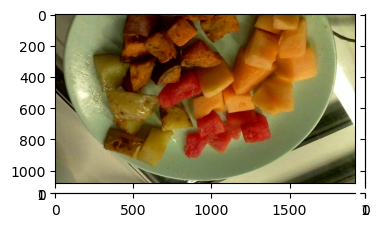

dish_1558114284 : 


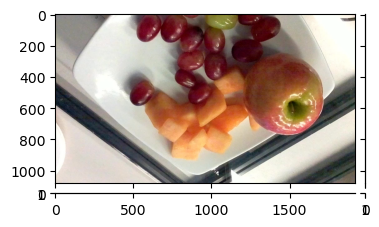

dish_1558028772 : 


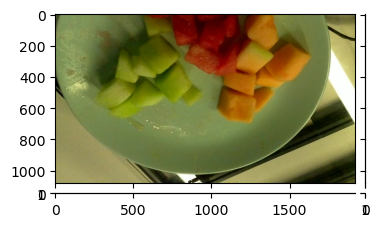

dish_1558031351 : 


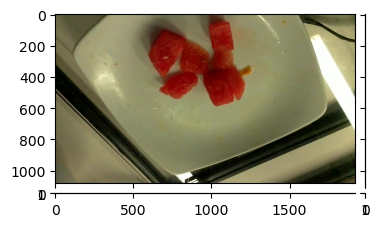

dish_1558376768 : 


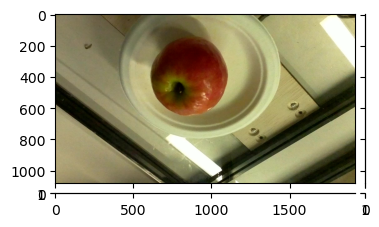

dish_1558372771 : 


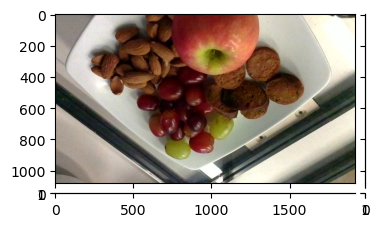

dish_1558380181 : 


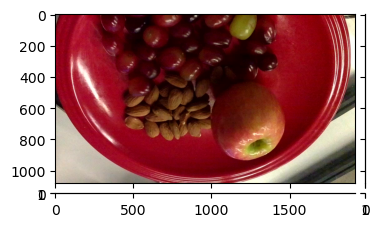

dish_1558028194 : 


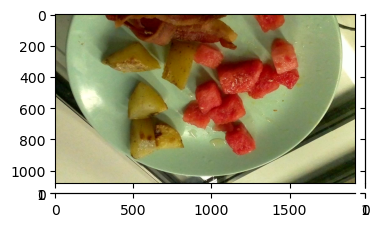

In [26]:
# Handling Invalid Ingredients
# For each dish with invalid ingredients, displays up to four images from the corresponding directory to visually inspect the dish.
for dish_id in rows_with_invalid_ingredients["dish_id"]:
    target_path = Path(f"./Food Datasets/final-dataset/images/generic/{dish_id}")
    fig = plt.figure(figsize=(4.0, 4.0))
    grid = ImageGrid(fig, 111, nrows_ncols=(2, 2), axes_pad=0.1)
    print(f"{dish_id} : ")
    for ax, image in zip(grid, target_path.iterdir()):
        img = Image.    open(image).convert("RGB")
        img = np.asarray(img)
        ax.imshow(img)
        plt.show()
        break

In [21]:
# Replace deprecated with either apple or watermelon based on images above
# Replaces occurrences of "deprecated" in the "Ingredients" column of cleaned_metadata with specific ingredients (e.g., "apple", "watermelon") based on mappings in replace_deprecated
# Displays the updated rows from cleaned_metadata to verify the replacements.
replace_deprecated = {
    "dish_1558372433": "apple",
    "dish_1558114086": "apple",
    "dish_1558027001": "watermelon",
    "dish_1558373159": "apple",
    "dish_1558115364": "apple",
    "dish_1558114875": "apple",
    "dish_1558375506": "apple",
    "dish_1558028142": "watermelon",
    "dish_1558031019": "watermelon",
    "dish_1558030724": "watermelon",
    "dish_1558109945": "apple",
    "dish_1558027243": "watermelon",
    "dish_1558373074": "apple",
    "dish_1558379876": "apple",
    "dish_1558115282": "apple",
    "dish_1558379588": "apple",
    "dish_1558376984": "apple",
    "dish_1558028606": "watermelon",
    "dish_1558122740": "apple",
    "dish_1558116547": "apple",
    "dish_1558115047": "apple",
    "dish_1558380152": "apple",
    "dish_1558375583": "apple",
    "dish_1558031394": "watermelon",
    "dish_1558114284": "apple",
    "dish_1558028772": "watermelon",
    "dish_1558031351": "watermelon",
    "dish_1558376768": "apple",
    "dish_1558372771": "apple",
    "dish_1558380181": "apple",
    "dish_1558028194": "watermelon",
}

for dish_id in replace_deprecated.keys():
    target_row = cleaned_metadata.loc[
        cleaned_metadata["dish_id"] == dish_id, "Ingredients"
    ]
    ingredients = target_row.values[0]
    ingredients = ingredients.replace("deprecated", replace_deprecated[dish_id])
    cleaned_metadata.at[target_row.index[0], "Ingredients"] = ingredients

In [22]:
# Check the update rows
for dish_id in replace_deprecated.keys():
    target_row = cleaned_metadata.loc[cleaned_metadata["dish_id"] == dish_id]
    display(target_row)

dish_id Category  Calorie(kcal)  Carbohydrate(g)  Protein(g)  \
5  dish_1558372433  generic           0.52            0.003        0.14   

   Fat(g) Ingredients  
5   0.002       apple

dish_id Category  Calorie(kcal)  Carbohydrate(g)  Protein(g)  \
86  dish_1558114086  generic           0.52            0.003        0.14   

    Fat(g) Ingredients  
86   0.002       apple

dish_id Category  Calorie(kcal)  Carbohydrate(g)  Protein(g)  \
190  dish_1558027001  generic            0.3            0.076       0.006   

     Fat(g) Ingredients  
190   0.001  watermelon

dish_id Category  Calorie(kcal)  Carbohydrate(g)  Protein(g)  \
489  dish_1558373159  generic       3.033943         0.091332    0.181512   

      Fat(g)            Ingredients  
489  0.23688  sausage,apple,almonds

dish_id Category  Calorie(kcal)  Carbohydrate(g)  Protein(g)  \
858  dish_1558115364  generic       1.550351         0.084677     0.12607   

       Fat(g)                   Ingredients  
858  0.086291  potatoes,apple,almonds,bacon

dish_id Category  Calorie(kcal)  Carbohydrate(g)  Protein(g)  \
1021  dish_1558114875  generic           0.52            0.003        0.14   

      Fat(g) Ingredients  
1021   0.002       apple

dish_id Category  Calorie(kcal)  Carbohydrate(g)  Protein(g)  \
1087  dish_1558375506  generic           0.52            0.003        0.14   

      Fat(g) Ingredients  
1087   0.002       apple

dish_id Category  Calorie(kcal)  Carbohydrate(g)  Protein(g)  \
1335  dish_1558028142  generic            0.3            0.076       0.006   

      Fat(g) Ingredients  
1335   0.001  watermelon

dish_id Category  Calorie(kcal)  Carbohydrate(g)  Protein(g)  \
1504  dish_1558031019  generic       1.047929         0.154437    0.037122   

        Fat(g)                           Ingredients  
1504  0.033269  yam,bacon,watermelon,honeydew melons

dish_id Category  Calorie(kcal)  Carbohydrate(g)  Protein(g)  \
1574  dish_1558030724  generic            0.3            0.076       0.006   

      Fat(g) Ingredients  
1574   0.001  watermelon

dish_id Category  Calorie(kcal)  Carbohydrate(g)  Protein(g)  \
1656  dish_1558109945  generic           0.52            0.003        0.14   

      Fat(g) Ingredients  
1656   0.002       apple

dish_id Category  Calorie(kcal)  Carbohydrate(g)  Protein(g)  \
1679  dish_1558027243  generic       1.615736         0.151521    0.076982   

        Fat(g)           Ingredients  
1679  0.078515  watermelon,bacon,yam

dish_id Category  Calorie(kcal)  Carbohydrate(g)  Protein(g)  \
1931  dish_1558373074  generic           0.52            0.003        0.14   

      Fat(g) Ingredients  
1931   0.002       apple

dish_id Category  Calorie(kcal)  Carbohydrate(g)  Protein(g)  \
2077  dish_1558379876  generic        3.07019         0.085952    0.182599   

        Fat(g)            Ingredients  
2077  0.240019  apple,sausage,almonds

dish_id Category  Calorie(kcal)  Carbohydrate(g)  Protein(g)  \
2181  dish_1558115282  generic           0.52            0.003        0.14   

      Fat(g) Ingredients  
2181   0.002       apple

dish_id Category  Calorie(kcal)  Carbohydrate(g)  Protein(g)  \
2199  dish_1558379588  generic           0.52            0.003        0.14   

      Fat(g) Ingredients  
2199   0.002       apple

dish_id Category  Calorie(kcal)  Carbohydrate(g)  Protein(g)  \
2450  dish_1558376984  generic        1.91908         0.086371    0.129829   

       Fat(g)                                Ingredients  
2450  0.13024  almonds,apple,sausage,mixed greens,grapes

dish_id Category  Calorie(kcal)  Carbohydrate(g)  Protein(g)  \
2618  dish_1558028606  generic            0.3            0.076       0.006   

      Fat(g) Ingredients  
2618   0.001  watermelon

dish_id Category  Calorie(kcal)  Carbohydrate(g)  Protein(g)  \
2654  dish_1558122740  generic       0.855757         0.074424    0.094141   

        Fat(g)                               Ingredients  
2654  0.025339  grapes,mixed greens,apple,potatoes,bacon

dish_id Category  Calorie(kcal)  Carbohydrate(g)  Protein(g)  \
2711  dish_1558116547  generic           0.52            0.003        0.14   

      Fat(g) Ingredients  
2711   0.002       apple

dish_id Category  Calorie(kcal)  Carbohydrate(g)  Protein(g)  \
2741  dish_1558115047  generic       0.960849         0.035689    0.120651   

        Fat(g)                 Ingredients  
2741  0.048972  mixed greens,almonds,apple

dish_id Category  Calorie(kcal)  Carbohydrate(g)  Protein(g)  \
2755  dish_1558380152  generic           0.52            0.003        0.14   

      Fat(g) Ingredients  
2755   0.002       apple

dish_id Category  Calorie(kcal)  Carbohydrate(g)  Protein(g)  \
3086  dish_1558375583  generic       1.538382         0.020813     0.14939   

        Fat(g)                 Ingredients  
3086  0.098251  mixed greens,sausage,apple

dish_id Category  Calorie(kcal)  Carbohydrate(g)  Protein(g)  \
3282  dish_1558031394  generic       0.746572         0.174453    0.013302   

        Fat(g)                         Ingredients  
3282  0.001638  cantaloupe,watermelon,potatoes,yam

dish_id Category  Calorie(kcal)  Carbohydrate(g)  Protein(g)  \
3398  dish_1558114284  generic       0.513386         0.071421    0.067472   

      Fat(g)              Ingredients  
3398   0.002  apple,grapes,cantaloupe

dish_id Category  Calorie(kcal)  Carbohydrate(g)  Protein(g)  \
3599  dish_1558028772  generic       0.333333         0.082083    0.006292   

        Fat(g)                            Ingredients  
3599  0.001318  watermelon,honeydew melons,cantaloupe

dish_id Category  Calorie(kcal)  Carbohydrate(g)  Protein(g)  \
3605  dish_1558031351  generic            0.3            0.076       0.006   

      Fat(g) Ingredients  
3605   0.001  watermelon

dish_id Category  Calorie(kcal)  Carbohydrate(g)  Protein(g)  \
3644  dish_1558376768  generic           0.52            0.003        0.14   

      Fat(g) Ingredients  
3644   0.002       apple

dish_id Category  Calorie(kcal)  Carbohydrate(g)  Protein(g)  \
3645  dish_1558372771  generic       1.680418         0.085881    0.123177   

        Fat(g)                   Ingredients  
3645  0.106048  apple,grapes,sausage,almonds

dish_id Category  Calorie(kcal)  Carbohydrate(g)  Protein(g)  \
3774  dish_1558380181  generic       1.197879          0.10454    0.092722   

        Fat(g)           Ingredients  
3774  0.058703  almonds,apple,grapes

dish_id Category  Calorie(kcal)  Carbohydrate(g)  Protein(g)  \
4507  dish_1558028194  generic       1.325872         0.104709    0.071035   

        Fat(g)                Ingredients  
4507  0.069209  bacon,watermelon,potatoes

In [23]:
# Write the cleaned metadata file
destination_file = Path("./Food Datasets/final-dataset/metadata/nutrition5k_metadata.csv")
cleaned_metadata.to_csv(destination_file, sep="\t", index=False, float_format="%.4f")

## Preprocess video to images

### Extract frames from side_angles directory

In [42]:
destination_dir = Path("./Food Datasets/final-dataset/images/generic")
source_dir = Path("./nutrition5k/imagery/side_angles")

In [43]:
# Processing Image Directories
for directory in source_dir.iterdir():
    output_dir = destination_dir / directory.name
    output_dir.mkdir()
    output_dir = output_dir.resolve().as_posix()
    print(output_dir)
    for video_file in directory.iterdir():
        input_file = video_file.resolve().as_posix()
        os.system(
            'ffmpeg -i "{input_file}" -vf "select=not(mod(n\,5))" -fps_mode vfr "{output_dir}/{camera_name}_frame_%03d.jpeg"'.format(
                input_file=input_file,
                output_dir=output_dir,
                camera_name=video_file.stem,
            )
        )

C:/Users/kenan/Desktop/food_v5/Food Datasets/final-dataset/images/generic/dish_1550704750
C:/Users/kenan/Desktop/food_v5/Food Datasets/final-dataset/images/generic/dish_1550704903
C:/Users/kenan/Desktop/food_v5/Food Datasets/final-dataset/images/generic/dish_1550705288
C:/Users/kenan/Desktop/food_v5/Food Datasets/final-dataset/images/generic/dish_1550705370
C:/Users/kenan/Desktop/food_v5/Food Datasets/final-dataset/images/generic/dish_1550705445
C:/Users/kenan/Desktop/food_v5/Food Datasets/final-dataset/images/generic/dish_1550705477
C:/Users/kenan/Desktop/food_v5/Food Datasets/final-dataset/images/generic/dish_1550705504
C:/Users/kenan/Desktop/food_v5/Food Datasets/final-dataset/images/generic/dish_1550705535
C:/Users/kenan/Desktop/food_v5/Food Datasets/final-dataset/images/generic/dish_1550705580
C:/Users/kenan/Desktop/food_v5/Food Datasets/final-dataset/images/generic/dish_1550705623
C:/Users/kenan/Desktop/food_v5/Food Datasets/final-dataset/images/generic/dish_1550705669
C:/Users/k

In [44]:
# Remove fault frames discovered
# Files begin from "D:\School Materials\FoodNet\Food Datasets\final-dataset\images\generic\dish_1575393132" have issues for camera B and C frames
destination_dir = Path("./Food Datasets/final-dataset/images/generic")
faulty_dir = [
    "dish_1576171204",
    "dish_1576171237",
    "dish_1576183111",
    "dish_1576258613",
    "dish_1576258657",
    "dish_1576258685",
    "dish_1576259732",
    "dish_1576259776",
    "dish_1575393132",
    "dish_1575404926",
    "dish_1575407477",
    "dish_1575478635",
    "dish_1575478663",
    "dish_1575481406",
    "dish_1575481443",
    "dish_1575653017",
    "dish_1575664962",
    "dish_1575923584",
    "dish_1575923893",
    "dish_1575997210",
    "dish_1575997241",
    "dish_1575997268",
    "dish_1575998399",
    "dish_1575999037",
    "dish_1576100046",
    "dish_1576171118",
    "dish_1576171157",
]

for directory in faulty_dir:
    path = destination_dir / directory
    print(path.resolve())
    all_files = [
        file
        for file in path.iterdir()
        if file.name.__contains__("camera_B") or file.name.__contains__("camera_C")
    ]
    for file in all_files:
        file.unlink()
        print(str(file.resolve()) + " has been removed.")
    print("\n")

C:\Users\kenan\Desktop\food_v5\Food Datasets\final-dataset\images\generic\dish_1576171204
C:\Users\kenan\Desktop\food_v5\Food Datasets\final-dataset\images\generic\dish_1576171204\camera_B_frame_001.jpeg has been removed.
C:\Users\kenan\Desktop\food_v5\Food Datasets\final-dataset\images\generic\dish_1576171204\camera_B_frame_002.jpeg has been removed.
C:\Users\kenan\Desktop\food_v5\Food Datasets\final-dataset\images\generic\dish_1576171204\camera_B_frame_003.jpeg has been removed.
C:\Users\kenan\Desktop\food_v5\Food Datasets\final-dataset\images\generic\dish_1576171204\camera_B_frame_004.jpeg has been removed.
C:\Users\kenan\Desktop\food_v5\Food Datasets\final-dataset\images\generic\dish_1576171204\camera_B_frame_005.jpeg has been removed.
C:\Users\kenan\Desktop\food_v5\Food Datasets\final-dataset\images\generic\dish_1576171204\camera_B_frame_006.jpeg has been removed.
C:\Users\kenan\Desktop\food_v5\Food Datasets\final-dataset\images\generic\dish_1576171204\camera_B_frame_007.jpeg has 

### Preprocess single top images from realsense overhead directory

In [57]:
destination_dir = Path("./food_v5/Food Datasets/final-dataset/images/generic")
source_dir = Path("./nutrition5k/imagery/realsense_overhead")

In [58]:
for folder in source_dir.iterdir():
    if not folder.is_dir():
        continue  # Skip if it's not a directory

    output_dir = destination_dir / folder.name
    if output_dir.exists():
        print(f"The operations have been performed before for {folder.name}. Check the folder.")
        continue

    output_dir.mkdir()
    for file in folder.iterdir():
        if file.is_file():
            destination_path = output_dir / file.name
            try:
                shutil.copy(file, destination_path)
                print(f"Copied {file} to {destination_path}")
            except PermissionError as e:
                print(f"Permission error for {file}: {e}")


The operations have been performed before for dish_1556572657. Check the folder.
The operations have been performed before for dish_1556573514. Check the folder.
The operations have been performed before for dish_1556575014. Check the folder.
The operations have been performed before for dish_1556575083. Check the folder.
The operations have been performed before for dish_1556575124. Check the folder.
The operations have been performed before for dish_1556575273. Check the folder.
The operations have been performed before for dish_1556575327. Check the folder.
The operations have been performed before for dish_1556575386. Check the folder.
The operations have been performed before for dish_1556575446. Check the folder.
The operations have been performed before for dish_1556575499. Check the folder.
The operations have been performed before for dish_1556575558. Check the folder.
The operations have been performed before for dish_1556575700. Check the folder.
The operations have been per

## Writing all images file name for each dish_id

In [60]:
# Creates a CSV file listing all image files associated with each dish in cleaned_metadata, storing it as nutrition5k_all_images.csv
img_dir = Path("./Food Datasets/final-dataset/images")
rows = []
for dish_id in cleaned_metadata["dish_id"]:
    dish_dir = img_dir / "generic" / dish_id
    for img_path in dish_dir.iterdir():
        assert (
            img_path.suffix == ".jpeg" or img_path.suffix == ".png"
        ), f"{img_path} is not an expected image file"
        rows.append([img_path.name, dish_id, "nutrition5k"])
df_all_dish_images = pd.DataFrame(rows, columns=["ID/File Name", "dish_id", "dataset_name"])

In [61]:
destination_file = Path("./Food Datasets/final-dataset/metadata/nutrition5k_all_images.csv")
df_all_dish_images.to_csv(destination_file, index=False)

In [62]:
# Writes a text file (nutrition5k_train.txt) containing a corpus of ingredients for training embeddings.
write_to_file = []
for index, rows in cleaned_metadata.iterrows():
    ingredients_string = " ".join(rows["Ingredients"].split(","))
    write_to_file.append(ingredients_string)

with open(
    "./Ingredient Embeddings/recipe_corpus/nutrition5k_train.txt", "w"
) as file:
    file.write("\n".join(write_to_file))